# Intermittent Data

> In this notebook, we'll implement models for intermittent or sparse data using the M5 dataset.

Intermittent or sparse data has very few non-zero observations. This type of data is hard to forecast because the zero values increase the uncertainty about the underlying patterns in the data. Furthermore, once a non-zero observation occurs, there can be considerable variation in its size. Intermittent time series are common in many industries, including finance, retail, transportation, and energy. Given the ubiquity of this type of series, special methods have been developed to forecast them. The first was from [Croston (1972)](#ref), followed by several variants and by different aggregation frameworks. 

The models of [NeuralForecast](https://nixtla.github.io/statsforecast/) can be trained to model sparse or intermittent time series using a `Poisson` distribution loss. By the end of this tutorial, you'll have a good understanding of these models and how to use them. 

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Train models for intermittent data
4. Perform Cross Validation

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/IntermittentData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

::: {.callout-warning}
To reduce the computation time, it is recommended to use GPU. Using Colab, do not forget to activate it. Just go to `Runtime>Change runtime type` and select GPU as hardware accelerator.
::: 

## 1. Install libraries 

We assume that you have NeuralForecast already installed. If not, check this guide for instructions on [how to install NeuralForecast](https://nixtla.github.io/neuralforecast/examples/installation.html) 

Install the necessary packages using `pip install neuralforecast`

In [ ]:
%%capture
!pip install statsforecast s3fs fastparquet

In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git

## 2. Load and explore the data

For this example, we'll use a subset of the [M5 Competition](https://www.sciencedirect.com/science/article/pii/S0169207021001187#:~:text=The%20objective%20of%20the%20M5,the%20uncertainty%20around%20these%20forecasts) dataset. Each time series represents the unit sales of a particular product in a given Walmart store. At this level (product-store), most of the data is intermittent. 
We first need to import the data.

In [ ]:
import pandas as pd
from statsforecast import StatsForecast as sf

/usr/local/lib/python3.8/dist-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
Y_df = pd.read_parquet('https://m5-benchmarks.s3.amazonaws.com/data/train/target.parquet')
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

For simplicity sake we will keep just one category

In [ ]:
Y_df = Y_df.query('unique_id.str.startswith("FOODS_3")')
Y_df['unique_id'] = Y_df['unique_id'].astype(str)
Y_df = Y_df.reset_index(drop=True)

Plot some series using the plot method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic [EDA](https://nixtla.github.io/statsforecast/core.html#statsforecast.plot).

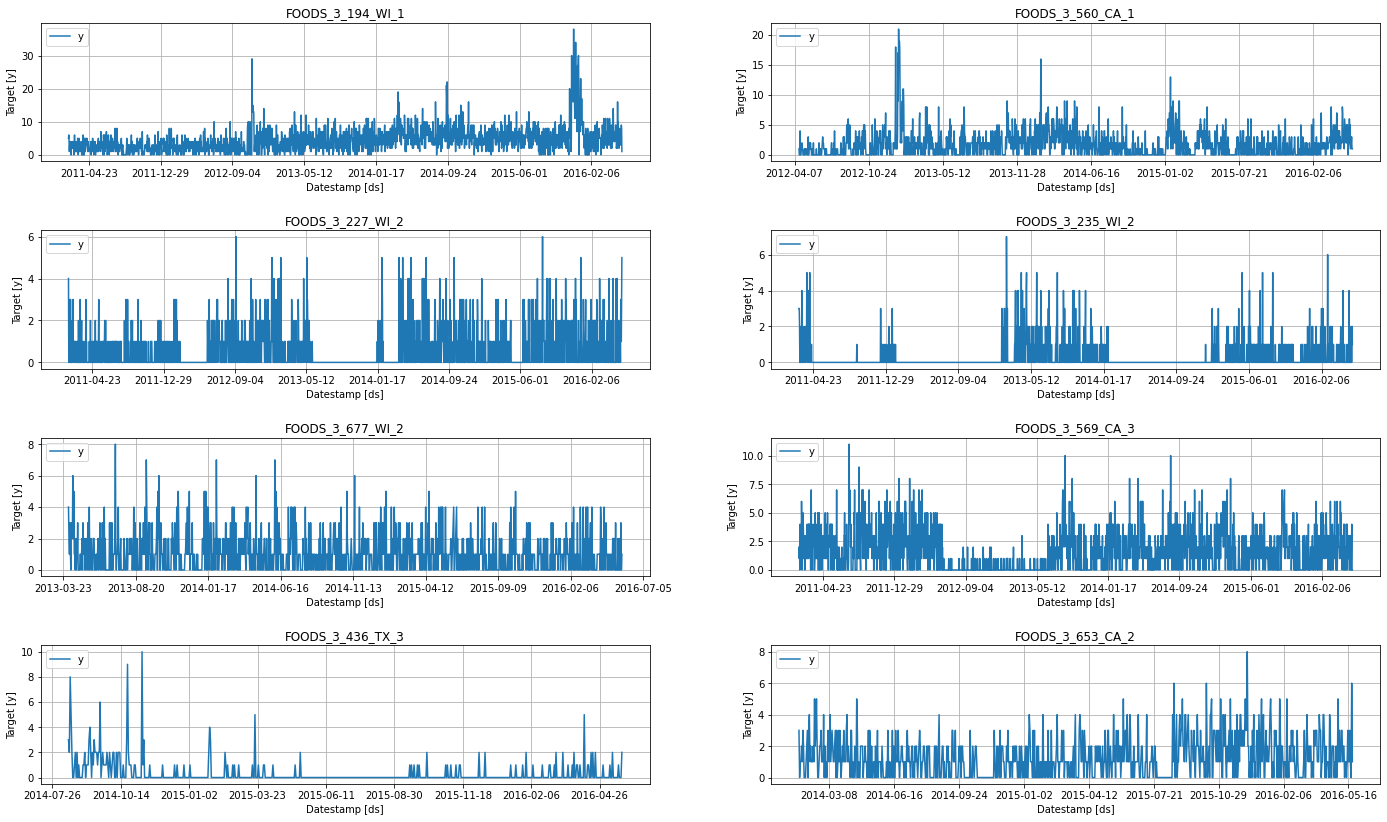

In [ ]:
sf.plot(Y_df, engine='matplotlib')

## 3. Train models for intermittent data 

In [ ]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoTFT
from neuralforecast.losses.pytorch import DistributionLoss

Each `Auto` model contains a default search space that was extensively tested on multiple large-scale datasets. Additionally, users can define specific search spaces tailored for particular datasets and tasks.

First, we create a custom search space for the `AutoNHITS` and `AutoTFT` models. Search spaces are specified with dictionaries, where keys corresponds to the model's hyperparameter and the value is a `Tune` function to specify how the hyperparameter will be sampled. For example, use `randint` to sample integers uniformly, and `choice` to sample values of a list.


In [ ]:
config_nhits = {
    "input_size": tune.choice([28, 28*2, 28*3, 28*5]),              # Length of input window
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[512, 512]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([32, 64, 128, 256]),                  # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512, 1024]),       # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}

config_tft = {
        "input_size": tune.choice([28, 28*2, 28*3]),                # Length of input window
        "hidden_size": tune.choice([64, 128, 256]),                 # Size of embeddings and encoders
        "learning_rate": tune.loguniform(1e-4, 1e-2),               # Initial learning rate
        "scaler_type": tune.choice([None]),                         # Scaler type
        "max_steps": tune.choice([500, 1000]),                      # Max number of training iterations
        "batch_size": tune.choice([32, 64, 128, 256]),              # Number of series in batch
        "windows_batch_size": tune.choice([128, 256, 512, 1024]),   # Number of windows in batch
        "random_seed": tune.randint(1, 20),                         # Random seed
    }

To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm (from `tune.search`), default is random search. Refer to https://docs.ray.io/en/latest/tune/api_docs/suggestion.html for more information on the different search algorithm options.
* `num_samples`: number of configurations explored.

In this example we set horizon `h` as 28, use the `Poisson` distribution loss (ideal for count data) for training and validation, and use the default search algorithm. 

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=False), num_samples=5),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=False), num_samples=2), 
    ],
    freq='D'
)

:::{.callout-tip}
The number of samples, `num_samples`, is a crucial parameter! Larger values will usually produce better results as we explore more configurations in the search space, but it will increase training times. Larger search spaces will usually require more samples. As a general rule, we recommend setting `num_samples` higher than 20.
:::

Next, we use the `Neuralforecast` class to train the `Auto` model. In this step, `Auto` models will automatically perform hyperparamter tuning training multiple models with different hyperparameters, producing the forecasts on the validation set, and evaluating them. The best configuration is selected based on the error on a validation set. Only the best model is stored and used during inference.

In [ ]:
%%capture
nf.fit(df=Y_df)

Next, we use the `predict` method to forecast the next 28 days using the optimal hyperparameters.

In [ ]:
fcst_df = nf.predict()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
fcst_df.columns = fcst_df.columns.str.replace('-median', '')

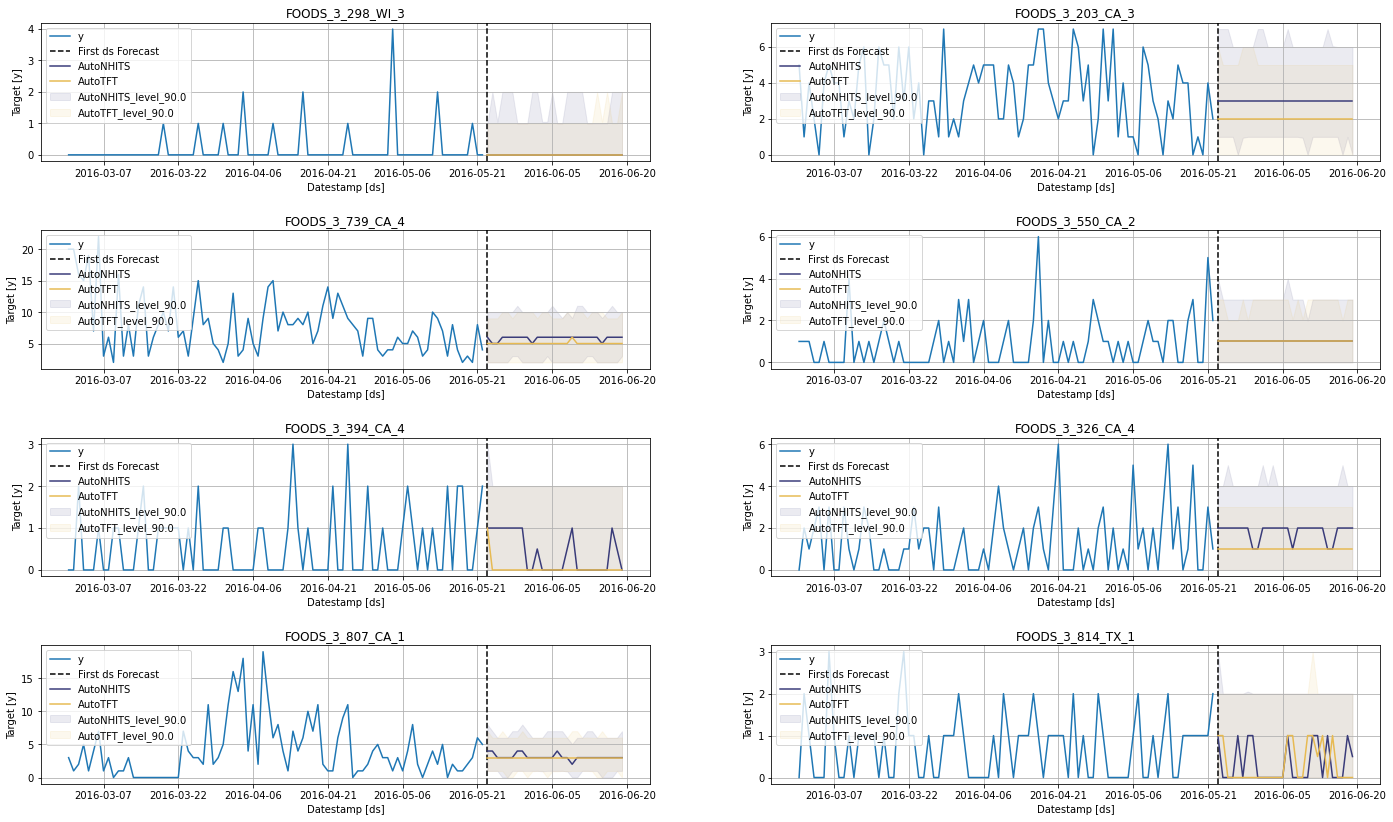

In [ ]:
sf.plot(Y_df, fcst_df, engine='matplotlib', max_insample_length=28 * 3)

## 4. Cross Validation


Time series cross-validation is a method for evaluating how a model would have performed in the past. It works by defining a sliding window across the historical data and predicting the period following it. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

[NeuralForecast](https://nixtla.github.io/neuralforecast/) has an implementation of time series cross-validation that is fast and easy to use.

The `cross_validation` method from the `NeuralForecast` class takes the following arguments.

- `df`: training data frame
- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=28, config=config_nhits, loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=False), num_samples=5),
        AutoTFT(h=28, config=config_tft, loss=DistributionLoss(distribution='Poisson', level=[80, 90], return_params=False), num_samples=2), 
    ],
    freq='D'
)

In [ ]:
%%capture
cv_df = nf.cross_validation(Y_df, n_windows=3, step_size=28)

The `cv_df` object is a new data frame that includes the following columns:

- `unique_id` index: (If you dont like working with index just run forecasts_cv_df.resetindex())
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
# cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90.0,AutoNHITS-lo-80.0,AutoNHITS-hi-80.0,AutoNHITS-hi-90.0,AutoTFT,AutoTFT-lo-90.0,AutoTFT-lo-80.0,AutoTFT-hi-80.0,AutoTFT-hi-90.0,y
0,FOODS_3_001_CA_1,2016-02-29,2016-02-28,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
1,FOODS_3_001_CA_1,2016-03-01,2016-02-28,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0
2,FOODS_3_001_CA_1,2016-03-02,2016-02-28,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,1.0
3,FOODS_3_001_CA_1,2016-03-03,2016-02-28,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0
4,FOODS_3_001_CA_1,2016-03-04,2016-02-28,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0


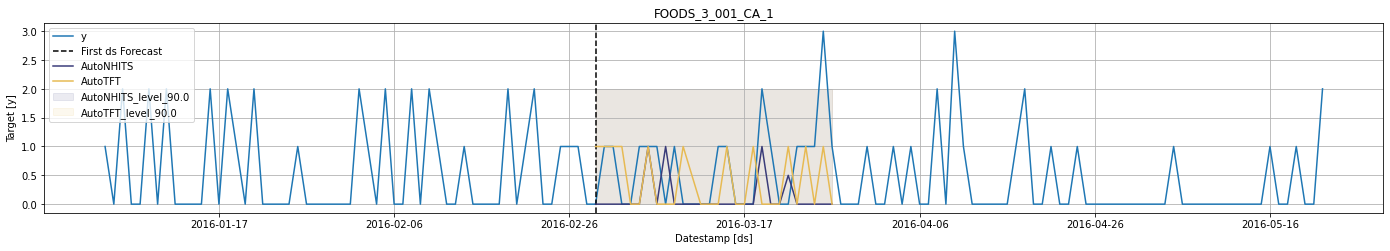

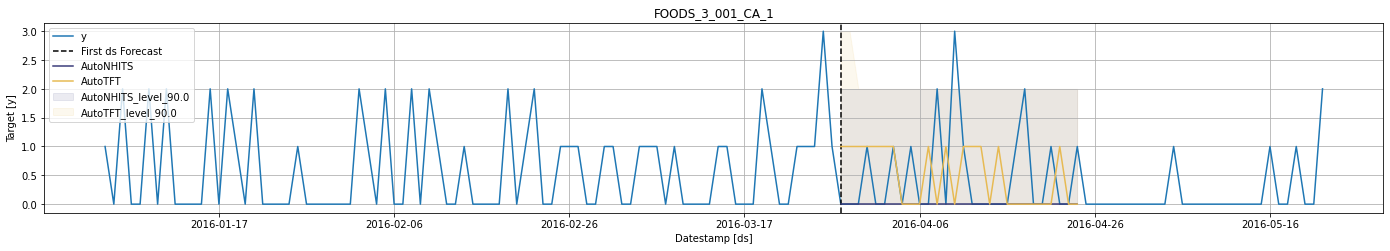

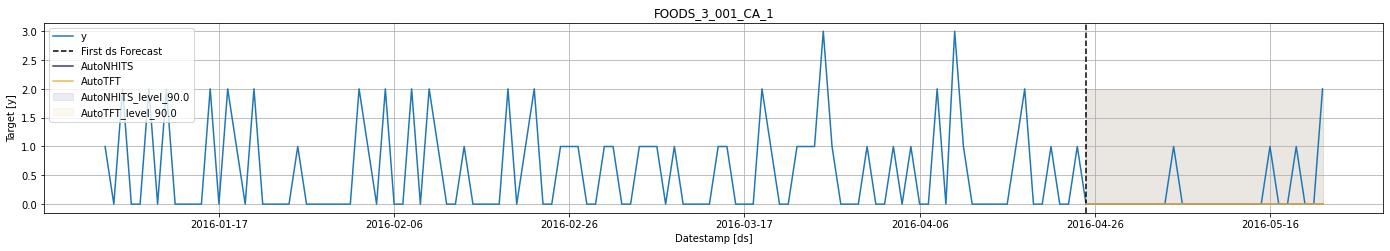

In [ ]:
for cutoff in cv_df['cutoff'].unique():
    sf.plot(Y_df, 
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']), 
            max_insample_length=28 * 5, 
            unique_ids=['FOODS_3_001_CA_1'],
            engine='matplotlib')

### Evaluate

In this section we will evaluate the performance of each model each cross validation window using the MSE metric.

In [ ]:
from neuralforecast.losses.numpy import mse, mae

In [ ]:
def evaluate(df):
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in [mse, mae]:
            eval_[model][metric.__name__] = metric(df['y'].values, df[model].values)
    eval_df = pd.DataFrame(eval_).rename_axis('metric')
    return eval_df

In [ ]:
cv_df.groupby('cutoff').apply(lambda df: evaluate(df))

AutoNHITS    AutoTFT
cutoff     metric                      
2016-02-28 mse     10.274085  15.240116
           mae      1.445398   1.511810
2016-03-27 mse      9.533789  14.307356
           mae      1.445806   1.520717
2016-04-24 mse      9.561473  14.719155
           mae      1.455149   1.534106


## References 

- [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50)
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)